In [1]:
# pip install torch torchvision

In [2]:
# pip install wandb

wandb: Appending key for api.wandb.ai to your netrc file: /Users/malakyehia/.netrc


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import wandb


In [5]:
class ConvBNActivation(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super().__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6(inplace=True)
        )

In [6]:
class InvertedResidualBlock(nn.Module):
    def __init__(self, inp, outp, stride, expand_ratio):
        super().__init__()
        self.stride = stride
        hidden_dim = int(inp * expand_ratio)
        self.use_shortcut = stride == 1 and inp == outp
        
        layers = []
        if expand_ratio != 1:
            layers.append(ConvBNActivation(inp, hidden_dim, kernel_size=1))
        layers += [
            ConvBNActivation(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim),
            nn.Conv2d(hidden_dim, outp, 1, 1, 0, bias=False),
            nn.BatchNorm2d(outp),
        ]
        self.conv_layers = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_shortcut:
            return x + self.conv_layers(x)
        else:
            return self.conv_layers(x)


In [22]:
class CustomMobileNetV2(nn.Module):
    def __init__(self, num_classes, inverted_block_configs, dropout_rate=0.0):
        super().__init__()
        self.first_layer = ConvBNActivation(3, 32, stride=2)
        self.inverted_blocks = nn.Sequential(
            *[InvertedResidualBlock(**cfg) for cfg in inverted_block_configs]
        )
        self.expansion_layer = ConvBNActivation(inverted_block_configs[-1]['outp'], 1280, kernel_size=1)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.classifier = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.first_layer(x)
        x = self.inverted_blocks(x)
        x = self.expansion_layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x) 
        x = self.classifier(x)
        return x


In [8]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [9]:
def imshow_with_labels(images, labels, predictions=None):
    images = torchvision.utils.make_grid(images)  
    images = images / 2 + 0.5  # unnormalize
    np_images = images.numpy()
    plt.imshow(np.transpose(np_images, (1, 2, 0)))
    title = 'True: ' + ' '.join(f'{classes[labels[j]]}' for j in range(4))
    if predictions is not None:
        title += '\nPred: ' + ' '.join(f'{classes[predictions[j]]}' for j in range(4))
    plt.title(title)
    plt.show()


In [10]:
def train_model(model, device, train_loader, optimizer, epoch, train_losses, train_accuracy):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        correct += predicted.eq(target.view_as(predicted)).sum().item()
        total += target.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    train_losses.append(avg_loss)
    train_accuracy.append(accuracy)

    print(f'Train Epoch: {epoch}\tLoss: {avg_loss:.6f}, Accuracy: {accuracy:.2f}%')
    wandb.log({"train_loss": avg_loss, "train_accuracy": accuracy, "epoch": epoch})


In [11]:
def evaluate_model(model, device, data_loader, epoch, eval_losses, eval_accuracy):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = nn.CrossEntropyLoss()(output, target)
            total_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct += predicted.eq(target.view_as(predicted)).sum().item()
            total += target.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = 100. * correct / total
    eval_losses.append(avg_loss)
    eval_accuracy.append(accuracy)

    print(f'Eval Epoch: {epoch}\tLoss: {avg_loss:.6f}, Accuracy: {accuracy:.2f}%')
    wandb.log({"eval_loss": avg_loss, "eval_accuracy": accuracy, "epoch": epoch})


In [12]:
def plot_metrics(train_losses, train_accuracy, eval_losses, eval_accuracy):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    axs[0, 0].plot(train_losses, label="Training Loss")
    axs[0, 0].set_title("Training Loss")

    axs[0, 1].plot(train_accuracy, label="Training Accuracy")
    axs[0, 1].set_title("Training Accuracy")

    axs[1, 0].plot(eval_losses, label="Evaluation Loss")
    axs[1, 0].set_title("Evaluation Loss")

    axs[1, 1].plot(eval_accuracy, label="Evaluation Accuracy")
    axs[1, 1].set_title("Evaluation Accuracy")

    plt.show()

In [13]:
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
device

device(type='mps')

In [14]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
cifar10_dataset = torchvision.datasets.CIFAR10(root='./data', download=True, train=True, transform=transform)


Files already downloaded and verified


In [15]:
def main(config, cifar10_dataset):
    with wandb.init(project="mobilenetv2_experiments", config=config):
        device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
        model = CustomMobileNetV2(config["num_classes"], config["inverted_block_configs"]).to(device)
        
        # Optimizer selection based on the config
        if config["optimizer"] == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
        
        scheduler = StepLR(optimizer, step_size=config["scheduler_step_size"])
        
        train_loader = DataLoader(cifar10_dataset, batch_size=config["batch_size"], shuffle=True)
        eval_loader = DataLoader(cifar10_dataset, batch_size=config["batch_size"], shuffle=False)
        train_losses, train_accuracy = [], []
        eval_losses, eval_accuracy = [], []

        for epoch in range(1, config["epochs"] + 1):
            train_model(model, device, train_loader, optimizer, epoch, train_losses, train_accuracy)
            evaluate_model(model, device, eval_loader, epoch, eval_losses, eval_accuracy)
            scheduler.step()

        
    plot_metrics(train_losses, train_accuracy, eval_losses, eval_accuracy)


In [16]:
original_architecture = [
    # Layer 1
    {"inp": 32, "outp": 16, "stride": 1, "expand_ratio": 1},
    # Layer 2
    {"inp": 16, "outp": 24, "stride": 2, "expand_ratio": 6},
    # Layer 3
    {"inp": 24, "outp": 24, "stride": 1, "expand_ratio": 6},
    # Layer 4
    {"inp": 24, "outp": 32, "stride": 2, "expand_ratio": 6},
    # Layer 5
    {"inp": 32, "outp": 32, "stride": 1, "expand_ratio": 6},
    # Layer 6
    {"inp": 32, "outp": 32, "stride": 1, "expand_ratio": 6},
    # Layer 7
    {"inp": 32, "outp": 64, "stride": 2, "expand_ratio": 6},
    # Layer 8
    {"inp": 64, "outp": 64, "stride": 1, "expand_ratio": 6},
    # Layer 9
    {"inp": 64, "outp": 64, "stride": 1, "expand_ratio": 6},
    # Layer 10
    {"inp": 64, "outp": 64, "stride": 1, "expand_ratio": 6},
    # Layer 11
    {"inp": 64, "outp": 96, "stride": 1, "expand_ratio": 6},
    # Layer 12
    {"inp": 96, "outp": 96, "stride": 1, "expand_ratio": 6},
    # Layer 13
    {"inp": 96, "outp": 96, "stride": 1, "expand_ratio": 6},
    # Layer 14
    {"inp": 96, "outp": 160, "stride": 2, "expand_ratio": 6},
    # Layer 15
    {"inp": 160, "outp": 160, "stride": 1, "expand_ratio": 6},
    # Layer 16
    {"inp": 160, "outp": 160, "stride": 1, "expand_ratio": 6},
    # Layer 17
    {"inp": 160, "outp": 320, "stride": 1, "expand_ratio": 6},
]


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: malak-y17. Use `wandb login --relogin` to force relogin


Train Epoch: 1	Loss: 1.829363, Accuracy: 31.95%
Eval Epoch: 1	Loss: 1.494182, Accuracy: 44.83%
Train Epoch: 2	Loss: 1.465229, Accuracy: 46.87%
Eval Epoch: 2	Loss: 1.362440, Accuracy: 51.73%
Train Epoch: 3	Loss: 1.299188, Accuracy: 53.63%
Eval Epoch: 3	Loss: 1.210518, Accuracy: 57.67%


wandb: Network error (ReadTimeout), entering retry loop.


Train Epoch: 4	Loss: 1.173059, Accuracy: 58.51%
Eval Epoch: 4	Loss: 1.019797, Accuracy: 64.05%


wandb: ERROR Error while calling W&B API: An internal error occurred. Please contact support. (<Response [500]>)


Train Epoch: 5	Loss: 1.061495, Accuracy: 62.98%
Eval Epoch: 5	Loss: 0.912446, Accuracy: 68.40%
Train Epoch: 6	Loss: 0.969877, Accuracy: 66.27%
Eval Epoch: 6	Loss: 0.839030, Accuracy: 70.94%
Train Epoch: 7	Loss: 0.907618, Accuracy: 68.44%
Eval Epoch: 7	Loss: 0.771538, Accuracy: 73.48%
Train Epoch: 8	Loss: 0.834613, Accuracy: 71.05%
Eval Epoch: 8	Loss: 0.739193, Accuracy: 74.38%
Train Epoch: 9	Loss: 0.777085, Accuracy: 73.17%
Eval Epoch: 9	Loss: 0.672887, Accuracy: 77.20%
Train Epoch: 10	Loss: 0.748733, Accuracy: 74.26%
Eval Epoch: 10	Loss: 0.617287, Accuracy: 79.14%
Train Epoch: 11	Loss: 0.560425, Accuracy: 80.53%
Eval Epoch: 11	Loss: 0.450550, Accuracy: 84.49%
Train Epoch: 12	Loss: 0.499181, Accuracy: 82.42%
Eval Epoch: 12	Loss: 0.415692, Accuracy: 86.00%
Train Epoch: 13	Loss: 0.462385, Accuracy: 83.94%
Eval Epoch: 13	Loss: 0.371698, Accuracy: 87.45%
Train Epoch: 14	Loss: 0.427734, Accuracy: 85.08%
Eval Epoch: 14	Loss: 0.343863, Accuracy: 88.50%
Train Epoch: 15	Loss: 0.405849, Accuracy

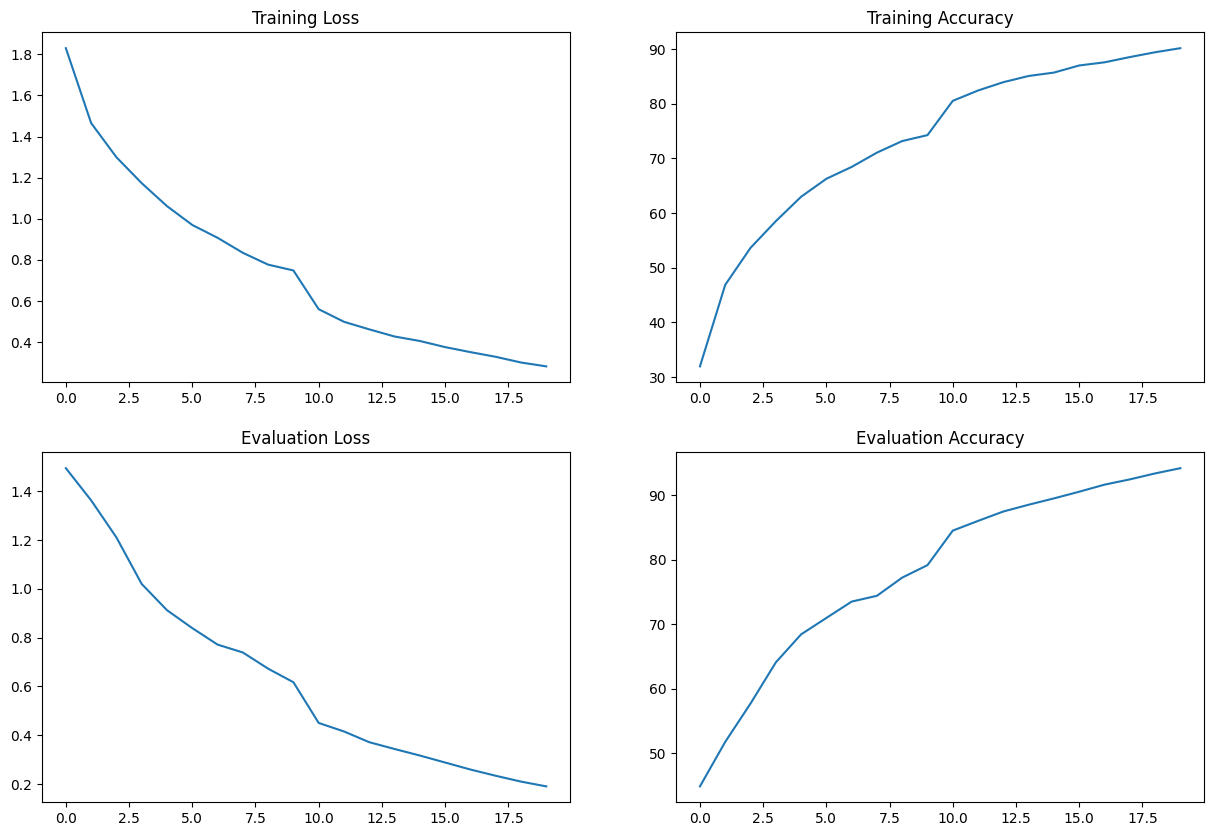

In [17]:
config1 = {
    "num_classes": 10,
    "learning_rate": 0.001,
    "batch_size": 64,
    "epochs": 20,
    "optimizer": "Adam",
    "scheduler_step_size": 10,
    "inverted_block_configs": original_architecture
}


main(config1, cifar10_dataset)

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▂▃▄▄▅▅▅▆▆▇▇▇▇▇▇████
eval_loss,█▇▆▅▅▄▄▄▄▃▂▂▂▂▂▂▁▁▁▁
train_accuracy,▁▃▄▄▅▅▅▆▆▆▇▇▇▇▇█████
train_loss,█▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
epoch,20
eval_accuracy,94.168
eval_loss,0.19075
train_accuracy,90.162
train_loss,0.28249


Train Epoch: 1	Loss: 1.839221, Accuracy: 32.21%
Eval Epoch: 1	Loss: 1.509290, Accuracy: 44.38%
Train Epoch: 2	Loss: 1.489434, Accuracy: 46.11%
Eval Epoch: 2	Loss: 1.328486, Accuracy: 51.81%
Train Epoch: 3	Loss: 1.319254, Accuracy: 53.10%
Eval Epoch: 3	Loss: 1.177432, Accuracy: 58.05%
Train Epoch: 4	Loss: 1.175998, Accuracy: 58.44%
Eval Epoch: 4	Loss: 1.047535, Accuracy: 63.77%
Train Epoch: 5	Loss: 1.063285, Accuracy: 62.93%
Eval Epoch: 5	Loss: 0.929459, Accuracy: 67.73%
Train Epoch: 6	Loss: 0.979013, Accuracy: 65.85%
Eval Epoch: 6	Loss: 0.856875, Accuracy: 70.79%
Train Epoch: 7	Loss: 0.907368, Accuracy: 68.75%
Eval Epoch: 7	Loss: 0.797989, Accuracy: 72.41%
Train Epoch: 8	Loss: 0.847740, Accuracy: 70.86%
Eval Epoch: 8	Loss: 0.727458, Accuracy: 75.55%
Train Epoch: 9	Loss: 0.785599, Accuracy: 72.89%
Eval Epoch: 9	Loss: 0.649359, Accuracy: 78.38%
Train Epoch: 10	Loss: 0.734449, Accuracy: 74.74%
Eval Epoch: 10	Loss: 0.617307, Accuracy: 78.99%
Train Epoch: 11	Loss: 0.559871, Accuracy: 80.81%

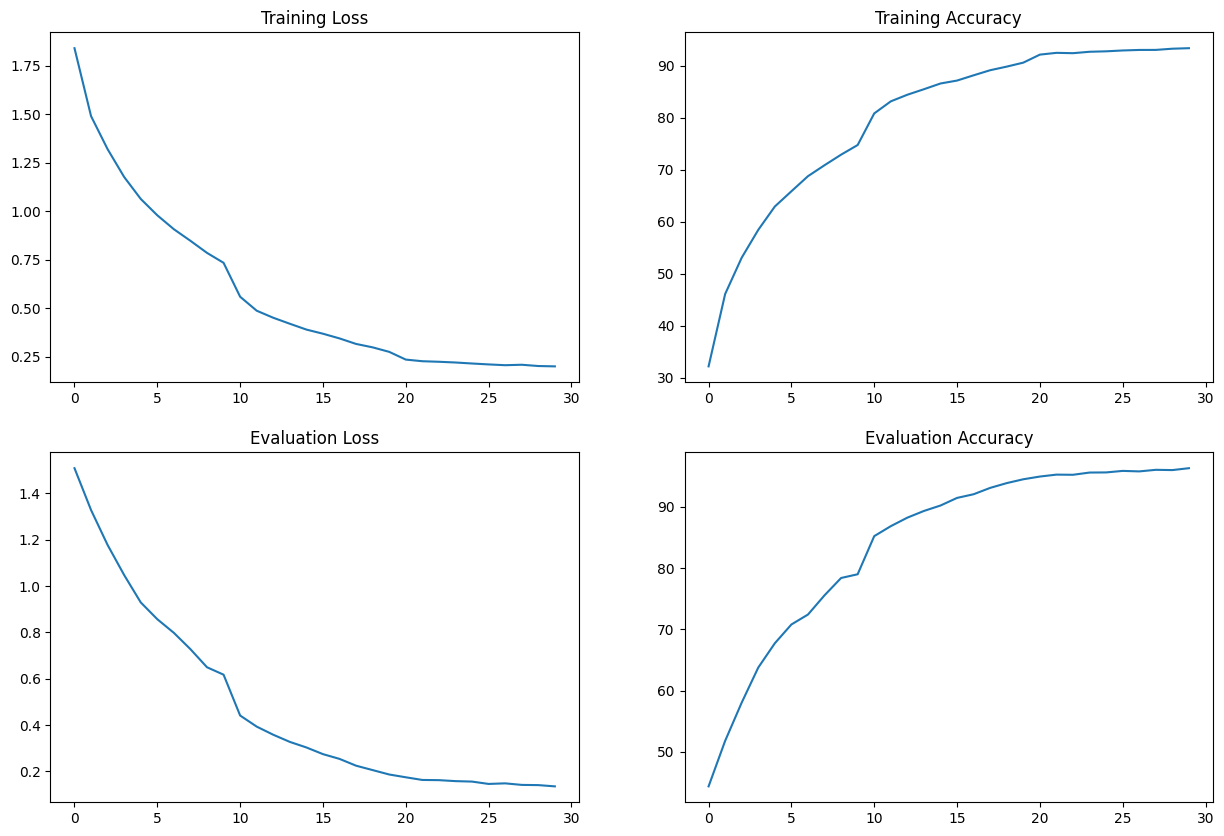

In [18]:
config2 = {
    "num_classes": 10,
    "learning_rate": 0.001,
    "batch_size": 64,
    "epochs": 30,
    "optimizer": "Adam",
    "scheduler_step_size": 10,
    "inverted_block_configs": original_architecture
}


main(config2, cifar10_dataset)

In [31]:
def main2(config, cifar10_dataset):
    wandb.init(project="mobilenetv2_experiments", config=config)
    device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
    model = CustomMobileNetV2(num_classes=config["num_classes"],
                          inverted_block_configs=config["inverted_block_configs"],
                          dropout_rate=config.get("dropout_rate", 0)).to(device)

    
    optimizer_params = config["optimizer"]["params"]
    if config["optimizer"]["type"] == "Adam":
        optimizer = optim.Adam(model.parameters(), **optimizer_params)
    
    scheduler = StepLR(optimizer, step_size=config["scheduler_step_size"])
    
    train_loader = DataLoader(cifar10_dataset, batch_size=config["batch_size"], shuffle=True)
    eval_loader = DataLoader(cifar10_dataset, batch_size=config["batch_size"], shuffle=False)
    train_losses, train_accuracy = [], []
    eval_losses, eval_accuracy = [], []

    for epoch in range(1, config["epochs"] + 1):
        train_model(model, device, train_loader, optimizer, epoch, train_losses, train_accuracy)
        evaluate_model(model, device, eval_loader, epoch, eval_losses, eval_accuracy)
        scheduler.step()

        
    plot_metrics(train_losses, train_accuracy, eval_losses, eval_accuracy)

epoch,▁▁██
eval_accuracy,▁█
eval_loss,█▁
train_accuracy,▁█
train_loss,█▁
epoch,2
eval_accuracy,41.266
eval_loss,1.59433
train_accuracy,37.406
train_loss,1.69239


Train Epoch: 1	Loss: 1.965482, Accuracy: 26.39%
Eval Epoch: 1	Loss: 1.637567, Accuracy: 39.56%
Train Epoch: 2	Loss: 1.589183, Accuracy: 41.34%
Eval Epoch: 2	Loss: 1.456047, Accuracy: 47.22%
Train Epoch: 3	Loss: 1.423152, Accuracy: 48.44%
Eval Epoch: 3	Loss: 1.254041, Accuracy: 54.82%
Train Epoch: 4	Loss: 1.294953, Accuracy: 53.73%
Eval Epoch: 4	Loss: 1.120909, Accuracy: 60.47%
Train Epoch: 5	Loss: 1.187303, Accuracy: 57.98%
Eval Epoch: 5	Loss: 1.033798, Accuracy: 63.73%
Train Epoch: 6	Loss: 1.095667, Accuracy: 61.56%
Eval Epoch: 6	Loss: 0.974022, Accuracy: 66.47%
Train Epoch: 7	Loss: 1.018918, Accuracy: 64.43%
Eval Epoch: 7	Loss: 0.874980, Accuracy: 70.09%
Train Epoch: 8	Loss: 0.949817, Accuracy: 66.88%
Eval Epoch: 8	Loss: 0.811931, Accuracy: 72.07%
Train Epoch: 9	Loss: 0.885635, Accuracy: 69.09%
Eval Epoch: 9	Loss: 0.744521, Accuracy: 74.68%
Train Epoch: 10	Loss: 0.830293, Accuracy: 71.18%
Eval Epoch: 10	Loss: 0.674602, Accuracy: 77.27%
Train Epoch: 11	Loss: 0.772087, Accuracy: 72.92%

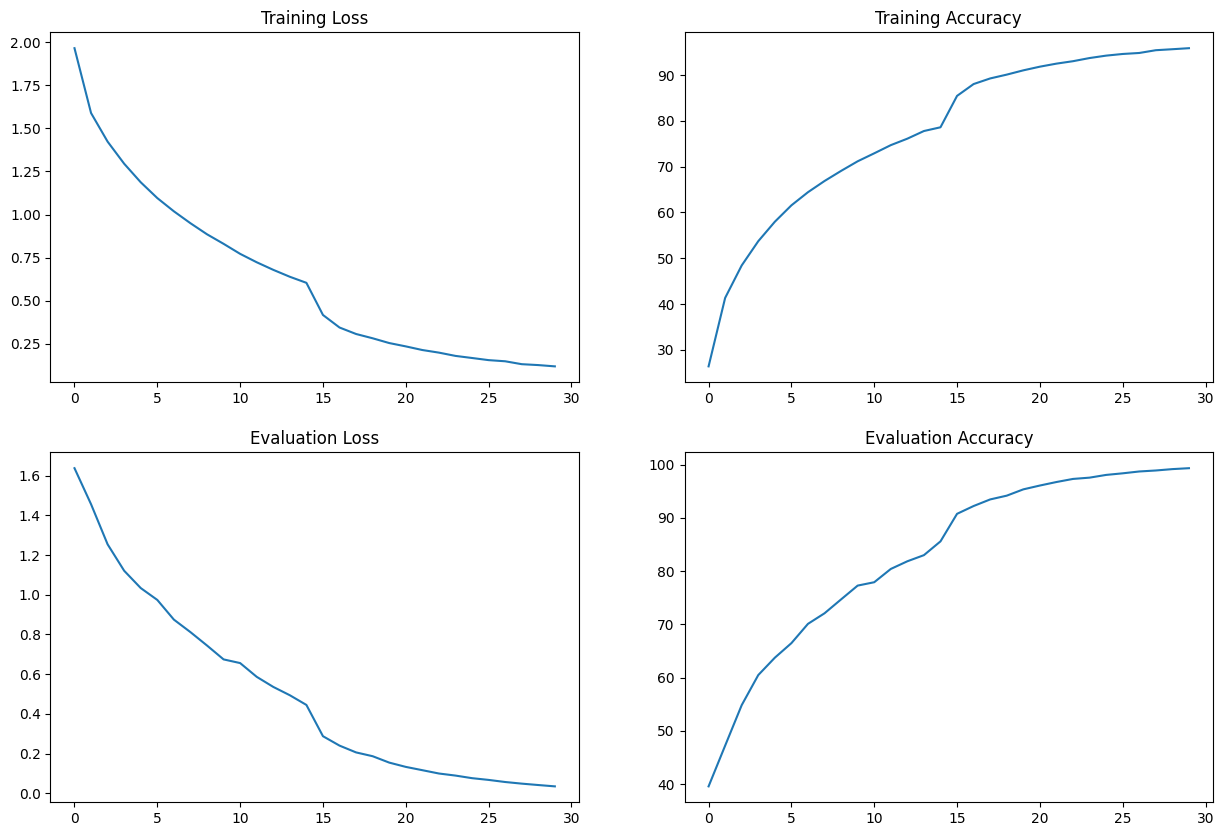

In [32]:
config3 = {
    "num_classes": 10,
    "learning_rate": 0.0005,
    "batch_size": 64,
    "epochs": 30,
    "optimizer": {
        "type": "Adam",
        "params": {
            "lr": 0.0005
        }
    },
    "scheduler_step_size": 15,
    "scheduler_gamma": 0.5,
    "inverted_block_configs": original_architecture
}
main2(config3, cifar10_dataset)

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval_accuracy,▁▂▃▃▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███████████
eval_loss,█▇▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇███████████
train_loss,█▇▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,99.326
eval_loss,0.03513
train_accuracy,95.888
train_loss,0.11919


Train Epoch: 1	Loss: 1.827011, Accuracy: 32.12%
Eval Epoch: 1	Loss: 1.533838, Accuracy: 43.42%
Train Epoch: 2	Loss: 1.462202, Accuracy: 47.10%
Eval Epoch: 2	Loss: 1.280536, Accuracy: 54.14%
Train Epoch: 3	Loss: 1.286177, Accuracy: 54.32%
Eval Epoch: 3	Loss: 1.149801, Accuracy: 58.73%
Train Epoch: 4	Loss: 1.154365, Accuracy: 59.37%
Eval Epoch: 4	Loss: 1.033489, Accuracy: 63.33%
Train Epoch: 5	Loss: 1.049526, Accuracy: 63.46%
Eval Epoch: 5	Loss: 0.909746, Accuracy: 68.73%
Train Epoch: 6	Loss: 0.963235, Accuracy: 66.74%
Eval Epoch: 6	Loss: 0.850526, Accuracy: 70.10%
Train Epoch: 7	Loss: 0.901509, Accuracy: 69.14%
Eval Epoch: 7	Loss: 0.852848, Accuracy: 71.14%
Train Epoch: 8	Loss: 0.843627, Accuracy: 71.13%
Eval Epoch: 8	Loss: 0.694024, Accuracy: 76.49%
Train Epoch: 9	Loss: 0.783235, Accuracy: 73.36%
Eval Epoch: 9	Loss: 0.704884, Accuracy: 76.06%
Train Epoch: 10	Loss: 0.742733, Accuracy: 74.60%
Eval Epoch: 10	Loss: 0.660832, Accuracy: 77.66%
Train Epoch: 11	Loss: 0.556099, Accuracy: 81.02%

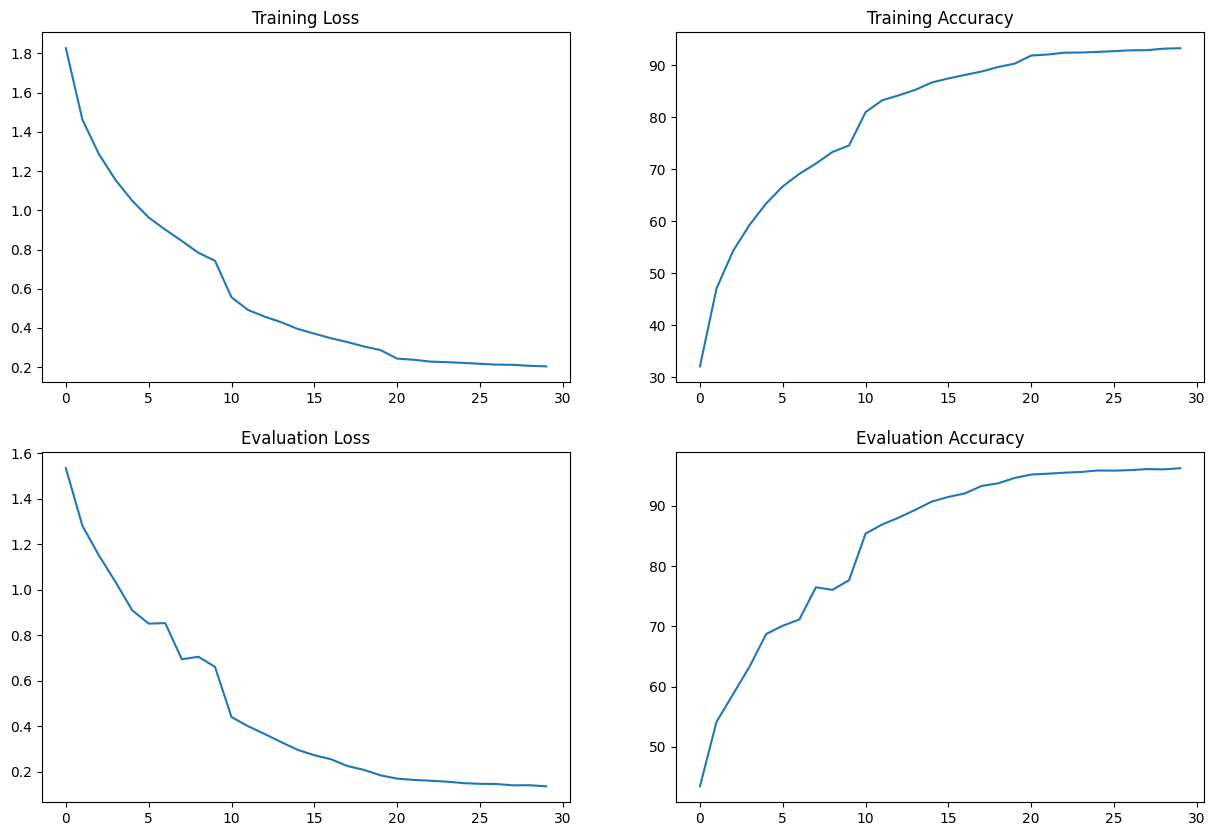

In [33]:
config4 = {
    "num_classes": 10,
    "learning_rate": 0.001,
    "batch_size": 64,
    "epochs": 30,
    "optimizer": {
        "type": "Adam",
        "params": {
            "lr": 0.001,
            "weight_decay": 1e-4
        }
    },
    "scheduler_step_size": 10,
    "scheduler_gamma": 0.5,
    "inverted_block_configs": original_architecture
}
main2(config4, cifar10_dataset)

In [34]:
augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=augmented_transform)


Files already downloaded and verified


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval_accuracy,▁▂▃▄▄▅▅▅▅▆▇▇▇▇▇▇▇█████████████
eval_loss,█▇▆▅▅▅▅▄▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▄▄▅▅▅▅▆▆▇▇▇▇▇▇▇▇████████████
train_loss,█▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,96.266
eval_loss,0.13523
train_accuracy,93.32
train_loss,0.20384


Train Epoch: 1	Loss: 1.933645, Accuracy: 27.45%
Eval Epoch: 1	Loss: 1.824642, Accuracy: 32.74%
Train Epoch: 2	Loss: 1.633712, Accuracy: 39.59%
Eval Epoch: 2	Loss: 1.521669, Accuracy: 43.84%
Train Epoch: 3	Loss: 1.491298, Accuracy: 45.16%
Eval Epoch: 3	Loss: 1.381184, Accuracy: 49.08%
Train Epoch: 4	Loss: 1.394246, Accuracy: 49.72%
Eval Epoch: 4	Loss: 1.334885, Accuracy: 51.53%
Train Epoch: 5	Loss: 1.343824, Accuracy: 51.69%
Eval Epoch: 5	Loss: 1.226195, Accuracy: 55.64%
Train Epoch: 6	Loss: 1.242809, Accuracy: 55.75%
Eval Epoch: 6	Loss: 1.196629, Accuracy: 57.27%
Train Epoch: 7	Loss: 1.177872, Accuracy: 57.95%
Eval Epoch: 7	Loss: 1.097584, Accuracy: 61.15%
Train Epoch: 8	Loss: 1.127480, Accuracy: 60.12%
Eval Epoch: 8	Loss: 1.053240, Accuracy: 62.84%
Train Epoch: 9	Loss: 1.076168, Accuracy: 62.02%
Eval Epoch: 9	Loss: 0.998905, Accuracy: 64.75%
Train Epoch: 10	Loss: 1.033545, Accuracy: 63.70%
Eval Epoch: 10	Loss: 0.941245, Accuracy: 66.61%
Train Epoch: 11	Loss: 0.921310, Accuracy: 67.45%

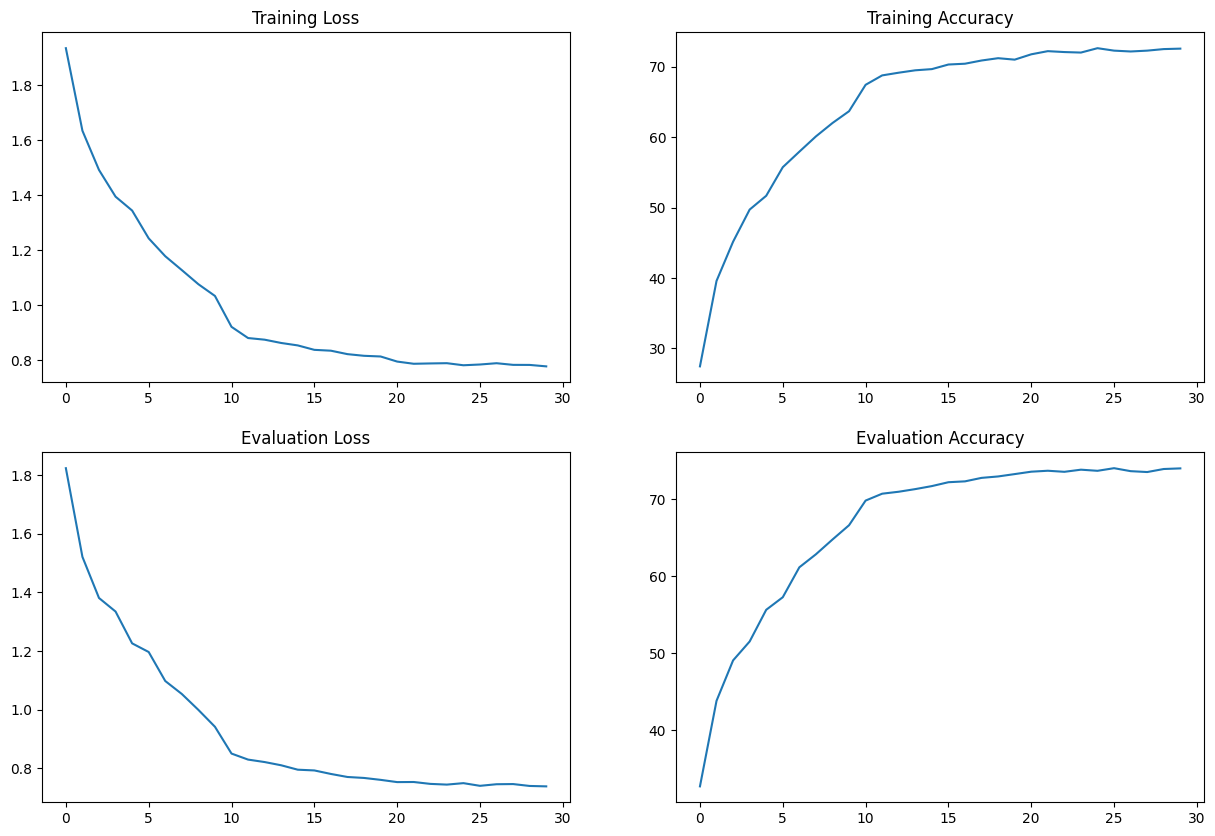

In [35]:
config5 = {
    "num_classes": 10,
    "learning_rate": 0.001,
    "batch_size": 64,
    "epochs": 30,
    "optimizer": {
        "type": "Adam",
        "params": {
            "lr": 0.001
        }
    },
    "scheduler_step_size": 10,
    "scheduler_gamma": 0.5,
    "inverted_block_configs": original_architecture,
    "data_transform": augmented_transform
}

main2(config5, cifar10_augmented)

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval_accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇█████████████████
eval_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇█████████████████
train_loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,73.98
eval_loss,0.73761
train_accuracy,72.592
train_loss,0.77769


Train Epoch: 1	Loss: 1.855464, Accuracy: 31.35%
Eval Epoch: 1	Loss: 1.540794, Accuracy: 42.80%
Train Epoch: 2	Loss: 1.505287, Accuracy: 45.25%
Eval Epoch: 2	Loss: 1.372908, Accuracy: 50.19%
Train Epoch: 3	Loss: 1.334174, Accuracy: 52.05%
Eval Epoch: 3	Loss: 1.193022, Accuracy: 55.30%
Train Epoch: 4	Loss: 1.212313, Accuracy: 56.85%
Eval Epoch: 4	Loss: 1.058155, Accuracy: 62.73%
Train Epoch: 5	Loss: 1.125416, Accuracy: 60.45%
Eval Epoch: 5	Loss: 1.014117, Accuracy: 64.32%
Train Epoch: 6	Loss: 1.054863, Accuracy: 63.24%
Eval Epoch: 6	Loss: 0.917934, Accuracy: 67.72%
Train Epoch: 7	Loss: 0.982459, Accuracy: 65.75%
Eval Epoch: 7	Loss: 0.865281, Accuracy: 69.93%
Train Epoch: 8	Loss: 0.911575, Accuracy: 68.41%
Eval Epoch: 8	Loss: 0.800343, Accuracy: 72.37%
Train Epoch: 9	Loss: 0.865709, Accuracy: 70.15%
Eval Epoch: 9	Loss: 0.728320, Accuracy: 75.23%
Train Epoch: 10	Loss: 0.798606, Accuracy: 72.34%
Eval Epoch: 10	Loss: 0.715685, Accuracy: 75.34%
Train Epoch: 11	Loss: 0.630751, Accuracy: 77.99%

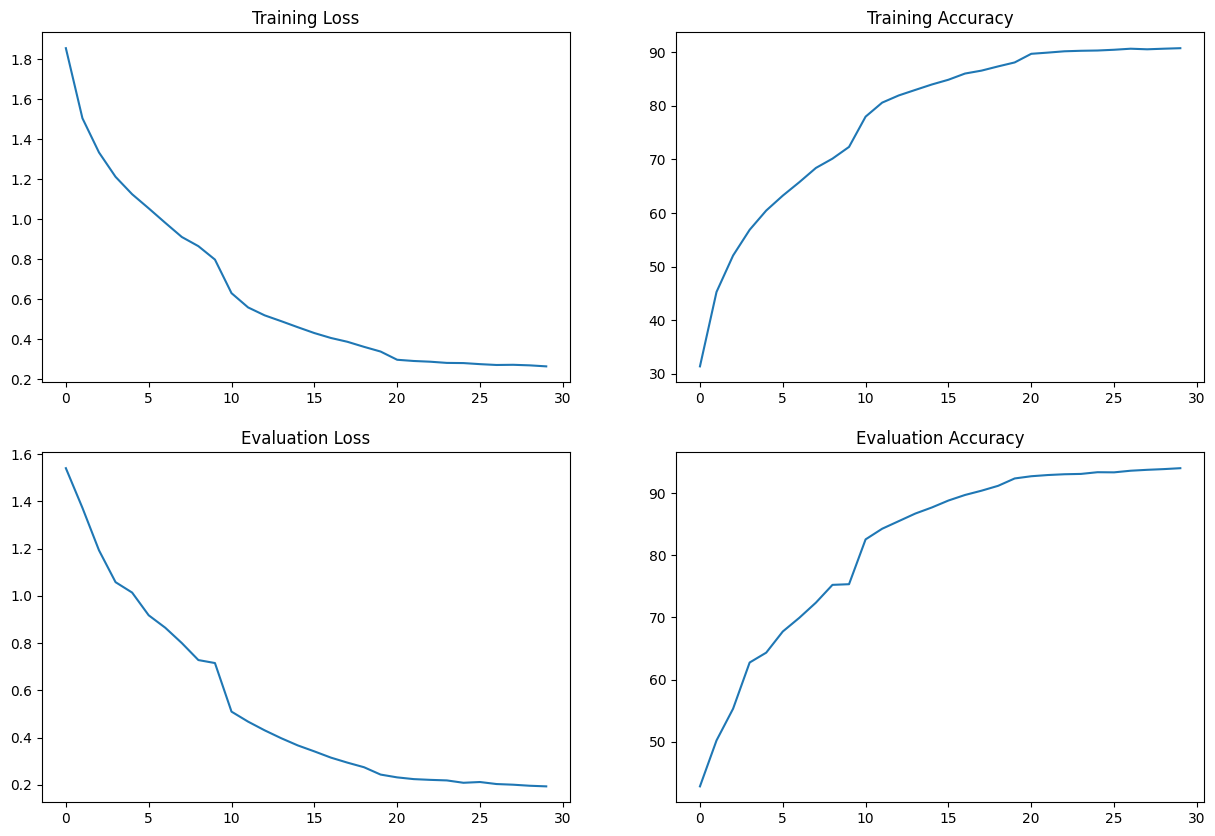

In [36]:
config6 = {
    "num_classes": 10,
    "learning_rate": 0.001,
    "batch_size": 64,
    "epochs": 30,
        "optimizer": {
        "type": "Adam",
        "params": {
            "lr": 0.001
        }
    },
    "scheduler_step_size": 10,
    "scheduler_gamma": 0.5,
    "inverted_block_configs": original_architecture,
    "dropout_rate": 0.2  
}
main2(config6, cifar10_dataset)

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval_accuracy,▁▂▃▄▄▄▅▅▅▅▆▇▇▇▇▇▇█████████████
eval_loss,█▇▆▅▅▅▄▄▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▃▄▄▅▅▅▆▆▆▇▇▇▇▇▇█████████████
train_loss,█▆▆▅▅▄▄▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,94.008
eval_loss,0.1935
train_accuracy,90.778
train_loss,0.26475


Train Epoch: 1	Loss: 1.985623, Accuracy: 25.82%
Eval Epoch: 1	Loss: 1.760217, Accuracy: 34.14%
Train Epoch: 2	Loss: 1.679697, Accuracy: 37.85%
Eval Epoch: 2	Loss: 1.576192, Accuracy: 42.36%
Train Epoch: 3	Loss: 1.529530, Accuracy: 44.19%
Eval Epoch: 3	Loss: 1.466951, Accuracy: 46.68%
Train Epoch: 4	Loss: 1.426510, Accuracy: 48.29%
Eval Epoch: 4	Loss: 1.363256, Accuracy: 51.04%
Train Epoch: 5	Loss: 1.337633, Accuracy: 52.17%
Eval Epoch: 5	Loss: 1.305372, Accuracy: 52.22%
Train Epoch: 6	Loss: 1.268169, Accuracy: 54.93%
Eval Epoch: 6	Loss: 1.197079, Accuracy: 56.65%
Train Epoch: 7	Loss: 1.199173, Accuracy: 57.53%
Eval Epoch: 7	Loss: 1.120219, Accuracy: 60.02%
Train Epoch: 8	Loss: 1.150004, Accuracy: 59.43%
Eval Epoch: 8	Loss: 1.100423, Accuracy: 60.54%
Train Epoch: 9	Loss: 1.101615, Accuracy: 61.15%
Eval Epoch: 9	Loss: 1.031462, Accuracy: 63.23%
Train Epoch: 10	Loss: 1.066447, Accuracy: 62.77%
Eval Epoch: 10	Loss: 0.982969, Accuracy: 65.43%
Train Epoch: 11	Loss: 0.949419, Accuracy: 66.41%

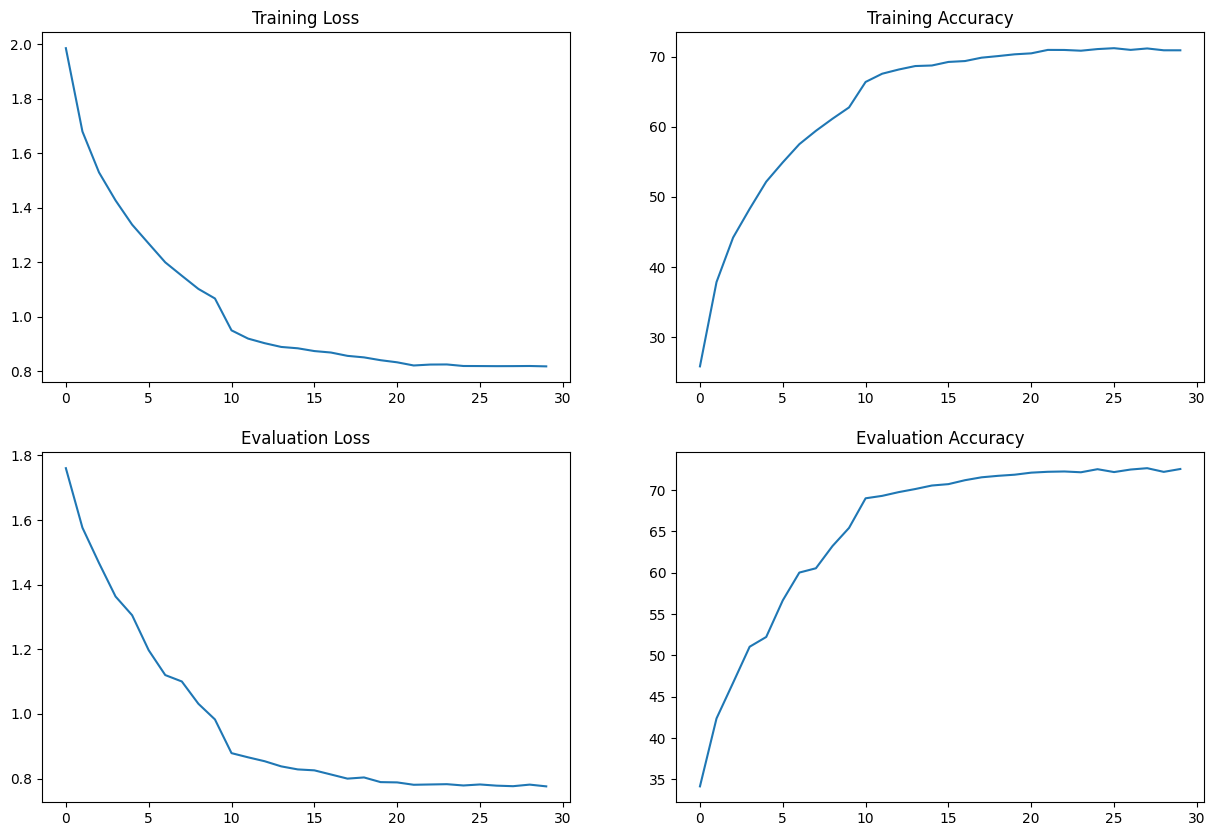

In [37]:
config7 = {
    "num_classes": 10,
    "learning_rate": 0.001,
    "batch_size": 64,
    "epochs": 30,
    "optimizer": {
        "type": "Adam",
        "params": {
            "lr": 0.001
        }
    },
    "scheduler_step_size": 10,
    "scheduler_gamma": 0.5,
    "inverted_block_configs": original_architecture,
    "data_transform": augmented_transform,
    "dropout_rate": 0.2
}
main2(config7, cifar10_augmented)


Trying Config 8

In [47]:
def main3(config, cifar10_dataset, exp_name):
    with wandb.init(project="mobilenetv2_experiments", config=config, name=exp_name) as run:
        device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
        model = CustomMobileNetV2(num_classes=config["num_classes"],
                                  inverted_block_configs=config["inverted_block_configs"],
                                  dropout_rate=config.get("dropout_rate", 0)).to(device)

        optimizer_params = config["optimizer"]["params"]
        if config["optimizer"]["type"] == "Adam":
            optimizer = optim.Adam(model.parameters(), **optimizer_params)

        if config.get("scheduler") == "ReduceLROnPlateau":
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, **config["scheduler_params"])
        else:
            scheduler = StepLR(optimizer, step_size=config["scheduler_step_size"], gamma=config["scheduler_gamma"])

        train_loader = DataLoader(cifar10_dataset, batch_size=config["batch_size"], shuffle=True)
        eval_loader = DataLoader(cifar10_dataset, batch_size=config["batch_size"], shuffle=False)
        train_losses, train_accuracy = [], []
        eval_losses, eval_accuracy = [], []

        for epoch in range(1, config["epochs"] + 1):
            train_model(model, device, train_loader, optimizer, epoch, train_losses, train_accuracy)
            evaluate_model(model, device, eval_loader, epoch, eval_losses, eval_accuracy)

            if config.get("scheduler") == "ReduceLROnPlateau":
                scheduler.step(eval_losses[-1]) 
            else:
                scheduler.step()

    plot_metrics(train_losses, train_accuracy, eval_losses, eval_accuracy)


Train Epoch: 1	Loss: 1.911856, Accuracy: 28.34%
Eval Epoch: 1	Loss: 1.669004, Accuracy: 37.63%
Train Epoch: 2	Loss: 1.595449, Accuracy: 40.89%
Eval Epoch: 2	Loss: 1.455023, Accuracy: 46.44%
Train Epoch: 3	Loss: 1.434612, Accuracy: 47.81%
Eval Epoch: 3	Loss: 1.326828, Accuracy: 52.02%
Train Epoch: 4	Loss: 1.312924, Accuracy: 52.73%
Eval Epoch: 4	Loss: 1.170816, Accuracy: 57.60%
Train Epoch: 5	Loss: 1.204505, Accuracy: 57.10%
Eval Epoch: 5	Loss: 1.065351, Accuracy: 62.30%
Train Epoch: 6	Loss: 1.120835, Accuracy: 60.12%
Eval Epoch: 6	Loss: 0.968356, Accuracy: 65.35%
Train Epoch: 7	Loss: 1.042854, Accuracy: 63.12%
Eval Epoch: 7	Loss: 0.898986, Accuracy: 69.24%
Train Epoch: 8	Loss: 0.850769, Accuracy: 69.77%
Eval Epoch: 8	Loss: 0.720717, Accuracy: 74.75%
Train Epoch: 9	Loss: 0.785299, Accuracy: 72.13%
Eval Epoch: 9	Loss: 0.670847, Accuracy: 76.59%
Train Epoch: 10	Loss: 0.743647, Accuracy: 73.66%
Eval Epoch: 10	Loss: 0.626991, Accuracy: 78.34%
Train Epoch: 11	Loss: 0.706471, Accuracy: 74.94%

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval_accuracy,▁▂▃▄▅▅▆▇▇▇▇▇██████████████████
eval_loss,█▇▆▅▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▄▄▅▅▆▇▇▇▇▇██████████████████
train_loss,█▆▆▅▄▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,84.648
eval_loss,0.45161
train_accuracy,80.224
train_loss,0.5551


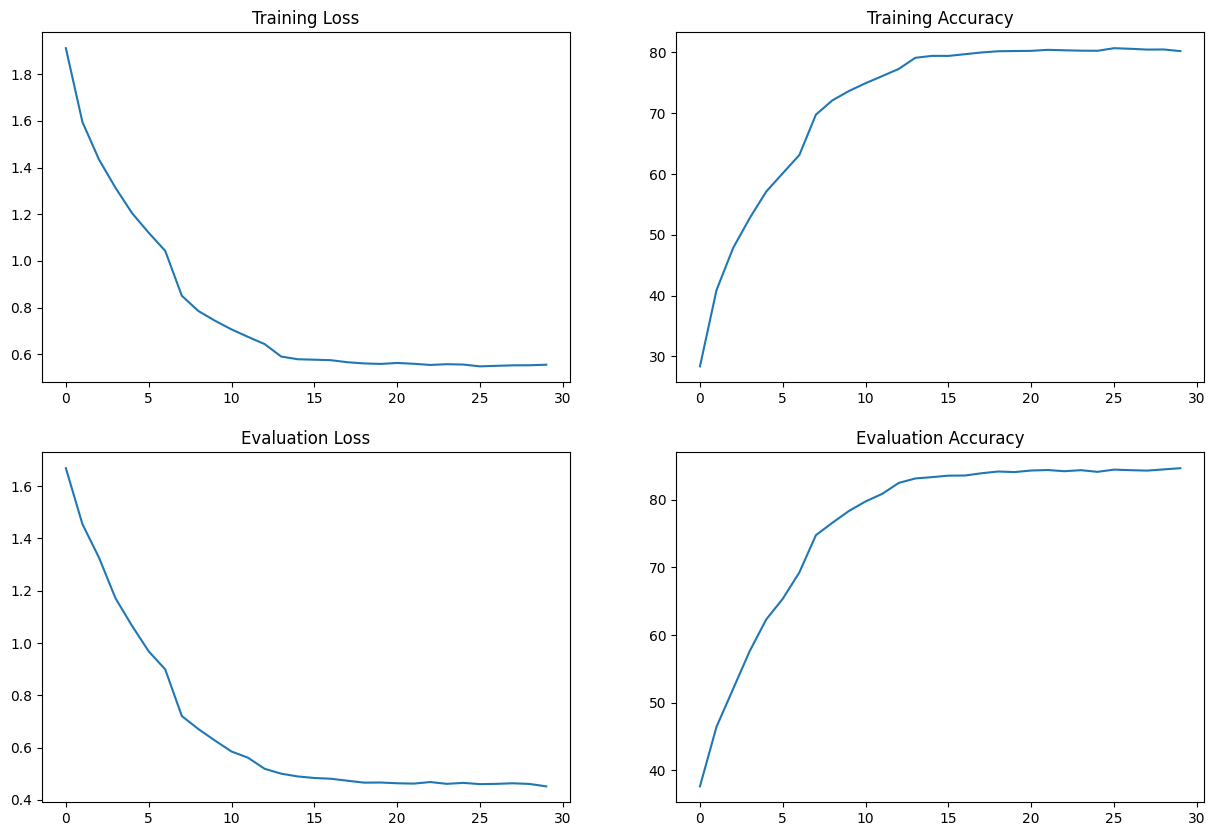

In [45]:
config8 = {
    "num_classes": 10,
    "learning_rate": 0.0005,
    "batch_size": 64,
    "epochs": 30,
    "optimizer": {
        "type": "Adam",
        "params": {
            "lr": 0.0005,
            "weight_decay": 1e-4
        }
    },
    "scheduler": "ReduceLROnPlateau",
    "scheduler_params": {
        "mode": 'max',
        "patience": 5,
        "threshold": 0.01,
        "min_lr": 1e-6,
        "eps": 1e-08
    },
    "inverted_block_configs": original_architecture,
}


main3(config8, cifar10_dataset, exp_name="config8_exp")

Train Epoch: 1	Loss: 1.991129, Accuracy: 25.99%
Eval Epoch: 1	Loss: 1.673728, Accuracy: 38.66%
Train Epoch: 2	Loss: 1.610598, Accuracy: 40.51%
Eval Epoch: 2	Loss: 1.419870, Accuracy: 48.05%
Train Epoch: 3	Loss: 1.437054, Accuracy: 47.58%
Eval Epoch: 3	Loss: 1.311814, Accuracy: 51.68%
Train Epoch: 4	Loss: 1.316436, Accuracy: 52.79%
Eval Epoch: 4	Loss: 1.173528, Accuracy: 58.55%
Train Epoch: 5	Loss: 1.215025, Accuracy: 56.90%
Eval Epoch: 5	Loss: 1.081570, Accuracy: 62.70%
Train Epoch: 6	Loss: 1.119534, Accuracy: 60.49%
Eval Epoch: 6	Loss: 0.980150, Accuracy: 66.36%
Train Epoch: 7	Loss: 1.038554, Accuracy: 63.67%
Eval Epoch: 7	Loss: 0.884229, Accuracy: 69.40%
Train Epoch: 8	Loss: 0.970297, Accuracy: 66.34%
Eval Epoch: 8	Loss: 0.831693, Accuracy: 71.20%
Train Epoch: 9	Loss: 0.904959, Accuracy: 68.65%
Eval Epoch: 9	Loss: 0.754170, Accuracy: 74.29%
Train Epoch: 10	Loss: 0.857095, Accuracy: 70.38%
Eval Epoch: 10	Loss: 0.717561, Accuracy: 75.54%
Train Epoch: 11	Loss: 0.800242, Accuracy: 72.33%

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval_accuracy,▁▂▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇████████████
eval_loss,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▂▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇███████████
train_loss,█▇▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,97.594
eval_loss,0.08304
train_accuracy,93.926
train_loss,0.1729


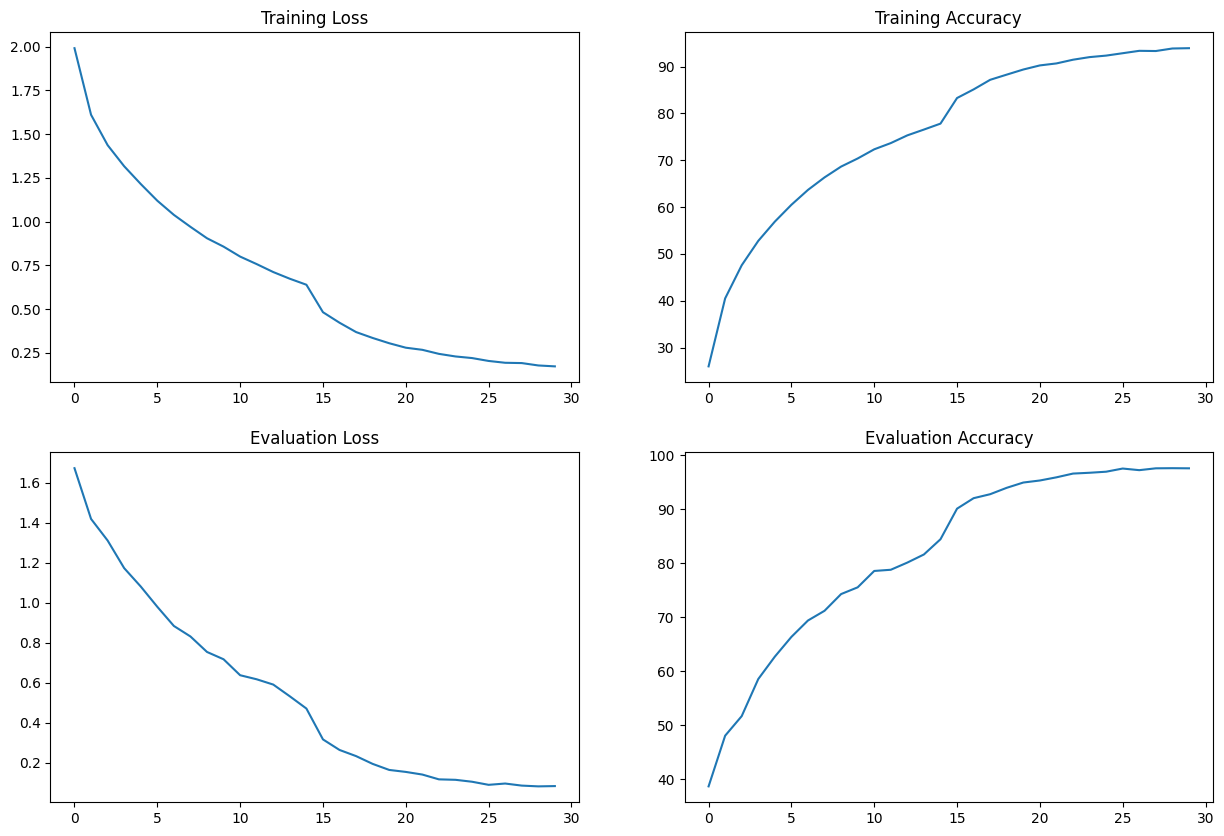

In [51]:
config9 = {
    "num_classes": 10,
    "learning_rate": 0.0005,
    "batch_size": 64,
    "epochs": 30,
    "optimizer": {
        "type": "Adam",
        "params": {
            "lr": 0.0005,
            "weight_decay": 1e-4  # L2 regularization
        }
    },
    "dropout_rate": 0.3,  # higher dropout 
    "scheduler_step_size": 15,
    "scheduler_gamma": 0.5,
    "inverted_block_configs": original_architecture
}

main3(config9, cifar10_dataset, "config9_exp")

Files already downloaded and verified


Train Epoch: 1	Loss: 2.103273, Accuracy: 21.26%
Eval Epoch: 1	Loss: 1.894702, Accuracy: 29.62%
Train Epoch: 2	Loss: 1.830797, Accuracy: 31.51%
Eval Epoch: 2	Loss: 1.729323, Accuracy: 35.78%
Train Epoch: 3	Loss: 1.700822, Accuracy: 37.14%
Eval Epoch: 3	Loss: 1.617376, Accuracy: 40.59%
Train Epoch: 4	Loss: 1.600833, Accuracy: 41.37%
Eval Epoch: 4	Loss: 1.538130, Accuracy: 43.66%
Train Epoch: 5	Loss: 1.523122, Accuracy: 44.28%
Eval Epoch: 5	Loss: 1.450502, Accuracy: 47.53%
Train Epoch: 6	Loss: 1.451342, Accuracy: 47.55%
Eval Epoch: 6	Loss: 1.396710, Accuracy: 48.83%
Train Epoch: 7	Loss: 1.387764, Accuracy: 50.53%
Eval Epoch: 7	Loss: 1.310633, Accuracy: 52.36%
Train Epoch: 8	Loss: 1.328493, Accuracy: 52.83%
Eval Epoch: 8	Loss: 1.257809, Accuracy: 55.35%
Train Epoch: 9	Loss: 1.272976, Accuracy: 54.86%
Eval Epoch: 9	Loss: 1.203114, Accuracy: 57.24%
Train Epoch: 10	Loss: 1.224093, Accuracy: 56.75%
Eval Epoch: 10	Loss: 1.132486, Accuracy: 59.98%
Train Epoch: 11	Loss: 1.186928, Accuracy: 58.25%

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval_accuracy,▁▂▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████████
eval_loss,█▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_accuracy,▁▂▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██████████
train_loss,█▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,73.744
eval_loss,0.75439
train_accuracy,71.618
train_loss,0.81681


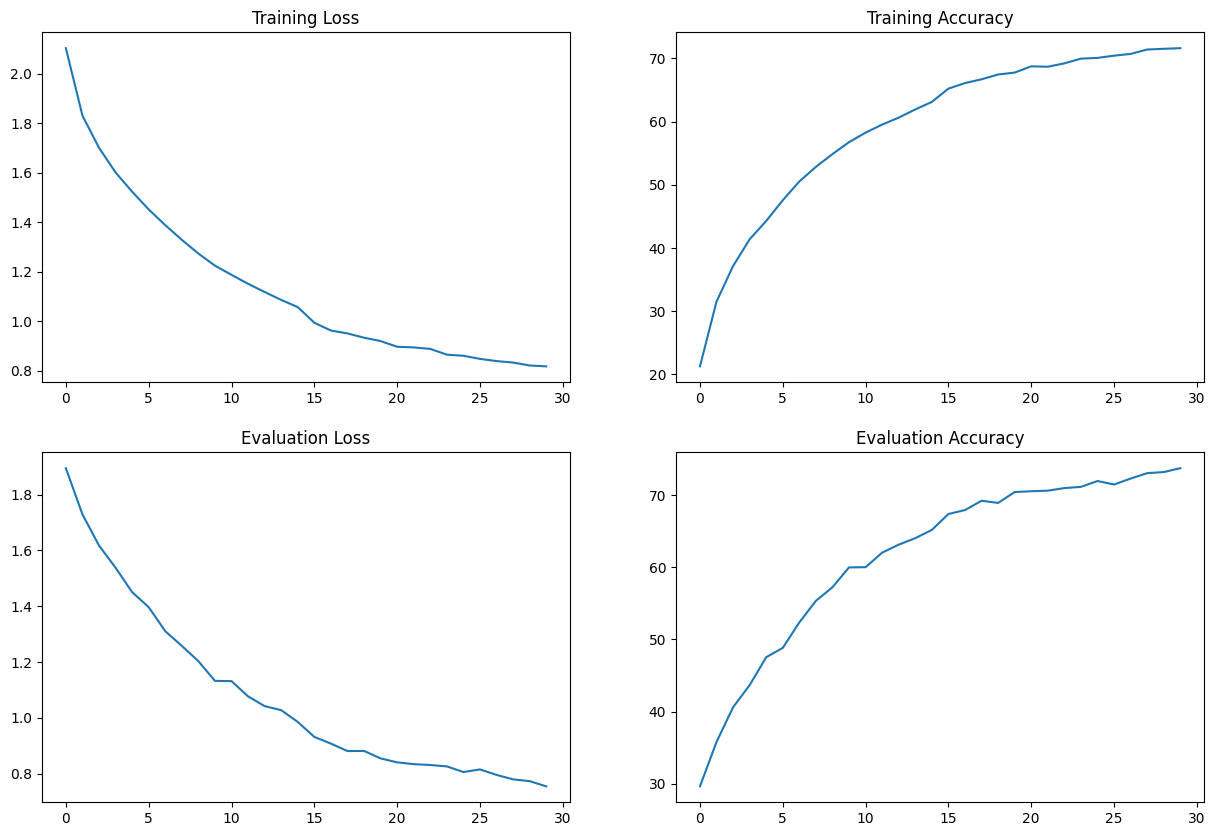

In [52]:
augmented_transform_2 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(15), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_augmented_2 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=augmented_transform_2)

config10 = {
    "num_classes": 10,
    "learning_rate": 0.0005,
    "batch_size": 64,
    "epochs": 30,
    "optimizer": {
        "type": "Adam",
        "params": {
            "lr": 0.0005
        }
    },
    "scheduler_step_size": 10,
    "scheduler_gamma": 0.5,
    "inverted_block_configs": original_architecture,
    "data_transform": augmented_transform_2  
}

main3(config9, cifar10_augmented_2, "config10_exp")
